## Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План выполнения проекта

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

# 1. Подготовка

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print('Размер датасета:', df.shape)

Размер датасета: (26496, 1)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим в хронологическом ли порядке расположены даты и время 

In [4]:
df.index.is_monotonic

True

Дата и время расположены в хронологическом порядке, можно не сортировать

In [5]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [6]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

Датасет с первого марта по 31 августа, за пол года.

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


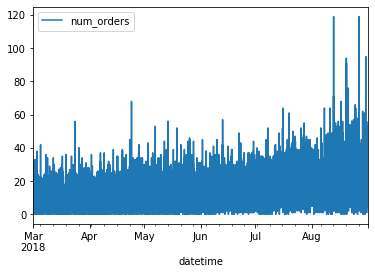

In [8]:
df.plot();

Сделаем ресемплирование по одному часу и посмотрим на результат

In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


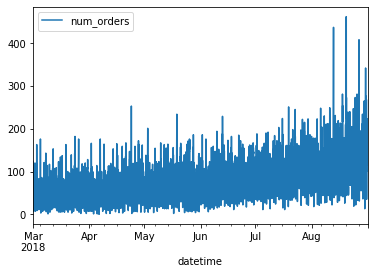

In [10]:
df.plot();

In [11]:
df.shape

(4416, 1)

Проверим на пропуски.

In [12]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(df)

,Total,Percent
num_orders,0,0.0


Пропусков нет. Данные подготовлены. Можно приступать к анализу.

# 2. Анализ

In [13]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [14]:
#Построим графики чтобы посмотреть на распределение
def dist_and_box(df, col):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'{col}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'{col}',fontsize=20); 

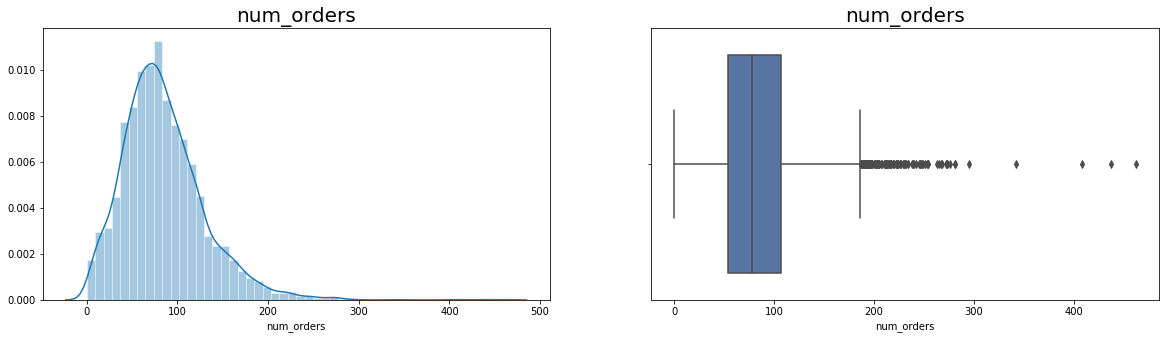

In [15]:
dist_and_box(df, 'num_orders')

In [16]:
df[df['num_orders'] > 200]

,num_orders
datetime,
2018-04-24 00:00:00,253
2018-05-03 00:00:00,201
2018-05-19 00:00:00,234
2018-06-13 02:00:00,229
2018-07-14 00:00:00,203
...,...
2018-08-31 09:00:00,203
2018-08-31 17:00:00,217
2018-08-31 18:00:00,207


Распределение выглядит нормальным, немного скошенным вправо, среднее 84 немного больше медианы 78. Выбросы объясняются увеличением заказов летом.

Посмотрим на графики, тренда, сезонности и остатков.

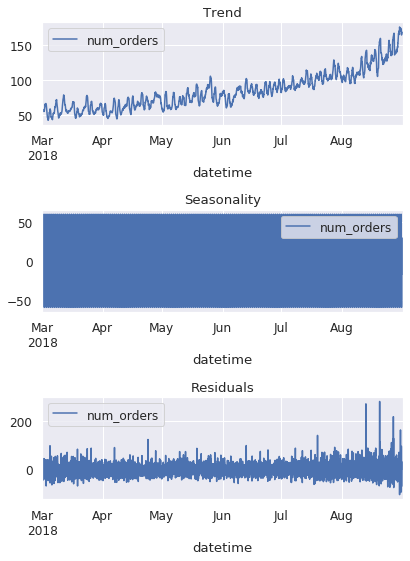

In [17]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд повышается начиная с лета и продолжает расти вплоть до сентября. Посмотрим на сезонность в более меньшем масштабе. Остатки это шум.

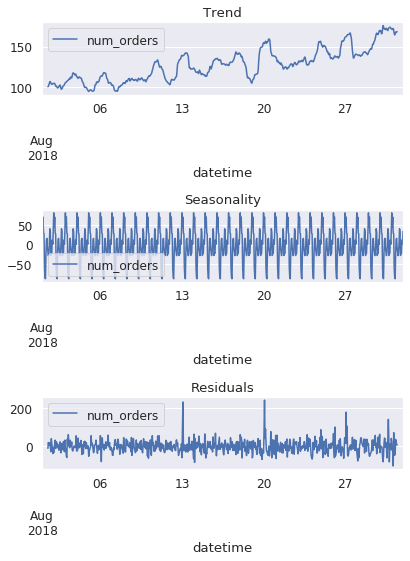

In [18]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31']) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В сезонности видна динамика, еще уменьшим масштаб.

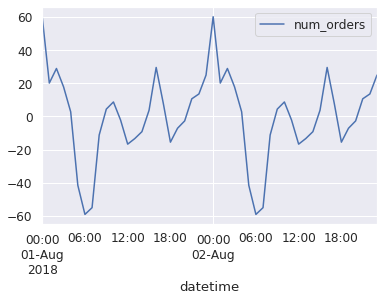

In [19]:
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca());

По сезонности видно, что к 6 утра количество заказов
увеличивается и достигает пика к 00.00 ночи, что закономерно.

Построим график скользящего среднего и скользящего стандартного отклонения.

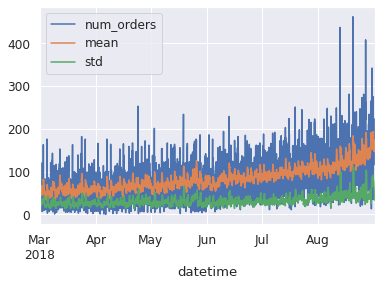

In [20]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot() 

Ряд не стационарный, у него меняется среднее значение и стандартное отклонение. Чтобы прогнозировать, ряд нужно будет сделать его более стационарным. Для этого найдем разность его значений.

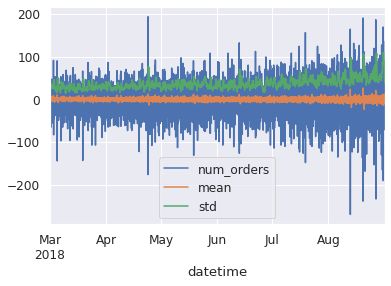

In [21]:
df_diff = df - df.shift() 
df_diff['mean'] = df_diff['num_orders'].rolling(15).mean()
df_diff['std'] = df_diff['num_orders'].rolling(15).std()
df_diff.plot();

Среднее стало ближе к нулю. Ряд стал более стационарным.
Есть три вида нестационарности: тренд, сезонность,
непостоянство дисперсии)
Стационарный ряд - это когда ничего из
перечисленного в ряде не наблюдается (очистили его).
Нужно это для одного из методов прогнозироваия АРИМА, например.
Для нашего метода прогнозирования это понятие можно не использовать.
Поэтому не будем обучать df_diff на разнице.

In [22]:
df = df.drop(labels=['mean','std'],axis=1)

# 3. Обучение

Модели обучались ооочень долго. Поэтому я использовал облачные вычисления в Colab от Google и DataSphere от Яндекса. А результат вычислений заносил сюда. В результате империческим путем было получено, что адекватная точность возникает при максимальном размере отставания 25 и ширины скользящего окна от 5, чаще от 25. 

Запустить можно в колабе https://colab.research.google.com/drive/1vgegn--tShwEfmqa5b-al1kMXvhIjQ4t?usp=sharing

Создадим новые признаки: Календарные, Отстающие значения, Скользящее среднее и вариации со скользящим средним по разностям в отдельном дата сете.

Не все факторы подходят, чисто логически:

1) Фактор год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, май.... Да и горизоно прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда <br>


In [23]:
def make_features(df_original, 
                  max_lag: int, 
                  rolling_mean_size: int, 
                  target_col='num_orders'):

    data = df_original.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target_col].shift(lag)

    data['rolling_mean'] = data[target_col].shift().rolling(rolling_mean_size).mean() 

    return data

In [24]:
# разделяем данные
def split_data(data, target_col='num_orders', size=0.1):
    train, test = train_test_split(data, shuffle=False, test_size=size)
    train = train.dropna()
    features_train = train.drop([target_col], axis=1)
    target_train = train[target_col]
    features_test = test.drop([target_col], axis=1)
    target_test = test[target_col]
    return features_train, features_test, target_train, target_test

Проверим, что разделение выборки работает корректно,
 тестовую сделаем 10% от изначальной, без перемешивания,
 модель не должна учиться на данных из будущего.

In [25]:
features_train, features_test, target_train, target_test = split_data(df)
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Выборки разделяются корректно.

In [26]:
# считаем метрики
def create_metrics(model, target_train, target_test, pred_train, pred_test):
    metrics = {}
    metrics["RMSE_train"] = round(mean_squared_error(target_train, pred_train)**0.5,4)
    metrics["RMSE_test"] = round(mean_squared_error(target_test, pred_test)**0.5,4)
    metrics["model"] = model
    return metrics

In [27]:
# обучаем и предсказываем модель
def fit_predict_data(model_callback, features_train, features_test, target_train, target_test):
    model = model_callback(features_train)
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    return create_metrics(model, target_train, target_test, pred_train, pred_test)

In [28]:
# получаем лучшую модель с лучшими параметрами
def get_best_params(df, model, max_lag_from=5, max_lag_to=10, rolling_from=5, rolling_to=10, show_work=True):
    best_RMSE_test = math.inf 
    best_metrics = {}
    for i in range(max_lag_from,max_lag_to+1,1):
        for j in range(rolling_from,rolling_to+1,1):
            data = make_features(df, max_lag=i, rolling_mean_size=j)
            metrics = fit_predict_data(model, *split_data(data))
            if show_work:
                print(f'i (max_lag) = {i}, j (rolling_mean_size) = {j} RMSE тестовой выборки: {metrics["RMSE_test"]}')
            if metrics["RMSE_test"] < best_RMSE_test:
                best_RMSE_test = metrics["RMSE_test"]
                best_metrics = metrics
                best_metrics["max_lag"] = i
                best_metrics["rolling_mean_size"] = j
                print(f'i (max_lag) = {i}, j (rolling_mean_size) = {j} RMSE тестовой выборки: {metrics["RMSE_test"]}')
                print(metrics['model'].best_params_)
            # это условие чтобы долго не ждать результата, 
            # полученные ниже метрики получены без этого условия при запуске в коллабе, но ждать долго
            if metrics["RMSE_test"] < 48:
                return best_metrics
    return best_metrics

Теперь обучим разные модели. (На всех моделях обучение выполняется долго).

## DecisionTreeRegressor

У нас временной ряд и валидационная
часть выборки при каждом разбиении должна быть
позже обучающей. Поэтому используем TimeSeriesSplit.

In [29]:
def get_model_decision_tree_regressor(features_train):
    parameters = {"criterion": ["mse"],
              "min_samples_split": [i for i in range(10,101,10)],
              "max_depth": [None],
              "min_samples_leaf": [i for i in range(10,101,10)],
              "max_leaf_nodes": [None],
              }
    
    split_index = TimeSeriesSplit().split(features_train)
    
    return GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), 
                        param_grid=parameters, cv=split_index, n_jobs=-1)

In [30]:
best_metrics_decision_tree_regressor = get_best_params(df, model=get_model_decision_tree_regressor,
                                                       max_lag_from=20, max_lag_to=30,
                                                      rolling_from=1, rolling_to=15)

i (max_lag) = 20, j (rolling_mean_size) = 1 RMSE тестовой выборки: 50.9748
i (max_lag) = 20, j (rolling_mean_size) = 1 RMSE тестовой выборки: 50.9748
{'criterion': 'mse', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 50}
i (max_lag) = 20, j (rolling_mean_size) = 2 RMSE тестовой выборки: 52.3212
i (max_lag) = 20, j (rolling_mean_size) = 3 RMSE тестовой выборки: 53.743
i (max_lag) = 20, j (rolling_mean_size) = 4 RMSE тестовой выборки: 53.0473
i (max_lag) = 20, j (rolling_mean_size) = 5 RMSE тестовой выборки: 51.8992
i (max_lag) = 20, j (rolling_mean_size) = 6 RMSE тестовой выборки: 51.7408
i (max_lag) = 20, j (rolling_mean_size) = 7 RMSE тестовой выборки: 55.2459
i (max_lag) = 20, j (rolling_mean_size) = 8 RMSE тестовой выборки: 49.6495
i (max_lag) = 20, j (rolling_mean_size) = 8 RMSE тестовой выборки: 49.6495
{'criterion': 'mse', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 60}
i (max_lag) = 20, j (roll

Получились метрики:
i (max_lag) = 20,  
j (rolling_mean_size) = 13  
RMSE тестовой выборки: 47.943 

In [31]:
best_metrics_decision_tree_regressor['model'].best_params_

{'criterion': 'mse',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 50}

Лучшие параметры:   
{'criterion': 'mse',  
'max_depth': None,   
'max_leaf_nodes': None,   
'min_samples_leaf': 10,  
'min_samples_split': 50}

## LinearRegression

In [32]:
def get_model_linear_regression(features_train):
    parameters = {'fit_intercept':[True,False], 
                  'copy_X':[True, False], 
                  'normalize':[True,False]}
    split_index = TimeSeriesSplit().split(features_train)
    return GridSearchCV(estimator=LinearRegression(), param_grid=parameters, cv=split_index,n_jobs=-1)

In [33]:
best_metrics_linear_regression = get_best_params(df, model=get_model_linear_regression, 
                                                 max_lag_from=22, max_lag_to=30,
                                                      rolling_from=20, rolling_to=30)

i (max_lag) = 22, j (rolling_mean_size) = 20 RMSE тестовой выборки: 48.5996
i (max_lag) = 22, j (rolling_mean_size) = 20 RMSE тестовой выборки: 48.5996
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
i (max_lag) = 22, j (rolling_mean_size) = 21 RMSE тестовой выборки: 48.5996
i (max_lag) = 22, j (rolling_mean_size) = 22 RMSE тестовой выборки: 48.5996
i (max_lag) = 22, j (rolling_mean_size) = 23 RMSE тестовой выборки: 45.2253
i (max_lag) = 22, j (rolling_mean_size) = 23 RMSE тестовой выборки: 45.2253
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


Получились метрики:
i (max_lag) = 22,   
j (rolling_mean_size) = 23  
RMSE тестовой: 45.2253

In [34]:
best_metrics_linear_regression['model'].best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

Параметры лучшей модели:  
{'copy_X': True,   
'fit_intercept': False,  
'normalize': True}

## RandomForestRegressor

In [35]:
def get_model_random_forest_regressor(features_train):
    parameters = {
        'bootstrap': [True, False],
        'max_depth': [5,10],
        'min_samples_leaf': [5,10],
        'min_samples_split': [5,10],
        'n_estimators': [100,200]
    }
    split_index = TimeSeriesSplit().split(features_train)
    return GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                         param_grid=parameters, 
                         cv=split_index,
                         n_jobs=-1)

In [36]:
best_metrics_random_forest_regressor = get_best_params(df,model=get_model_random_forest_regressor, 
                                                       max_lag_from=25, max_lag_to=30,
                                                      rolling_from=25, rolling_to=30)

i (max_lag) = 25, j (rolling_mean_size) = 25 RMSE тестовой выборки: 43.976
i (max_lag) = 25, j (rolling_mean_size) = 25 RMSE тестовой выборки: 43.976
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}


Получились метрики:
i (max_lag) = 25,  
j (rolling_mean_size) = 25  
RMSE тестовой: 43.976

In [37]:
best_metrics_random_forest_regressor['model'].best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 200}

Параметры лучшей модели:  
{'bootstrap': True,  
'max_depth': 10,  
'min_samples_leaf': 5,  
'min_samples_split': 5,  
'n_estimators': 200}

# 4. Тестирование

Во время обучения модели проводилось тестирование на
тестовой выборке из 10% от изначальной и по результатом
тестов выбирал лучшие параметры, все результаты приведены в таблице ниже.


| Модель                          | RMSE test |  max_lag | rolling_mean_size |
| :-------------------------------|----------:|---------:|------------------:|
| DecisionTreeRegressor           |   47.9430 |       20 |               13  |    
| LinearRegression                |   45.2253 |       22 |               23  |
| RandomForestRegressor           |   43.9760 |       25 |               25  |

## Выводы

Данные были подготовлены, и ресемплированы по одному часу. Проанализированы, ряд не стационарный, у него меняется среднее значение и стандартное отклонение. Далее добавлены новые признаки час, день недели, сдвиг и скользящее среднее. Обучены три модели DecisionTreeRegressor, LinearRegression, RandomForestRegressor для изначального датасета.

Точнее всех оказалась модель RandomForestRegressor (43.9760), но она очень долго обучается, пришлось задействовать сторониие ресурсы. Приемлемое качество LinearRegression (45.2253), по скорости значительно быстрее.  
  
Посмотрим как описываются совпадения предсказаний с реальными значениями на графиках.

In [52]:
def show_plot_compare_prediction_test(df, name, best):
    data =  make_features(df, best["max_lag"], best["rolling_mean_size"])
    data = data.dropna()
    features_train, features_test, target_train, target_test = split_data(data)
    df.loc[features_test.index,name] = best['model'].predict(features_test)
    df.loc[features_test.index].plot();

In [44]:
def show_plot_compare_prediction(df, name, best):
    data =  make_features(df, best["max_lag"], best["rolling_mean_size"])
    data = data.dropna()
    all_features = data.drop(['num_orders'], axis=1)
    df.loc[all_features.index,name] = best['model'].predict(all_features)
    df.plot();

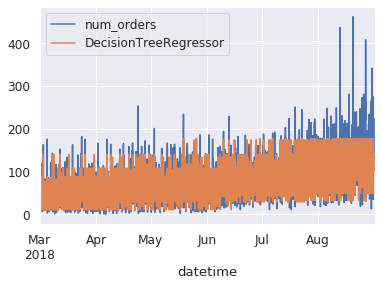

In [45]:
show_plot_compare_prediction(df.copy(), 'DecisionTreeRegressor',best_metrics_decision_tree_regressor)

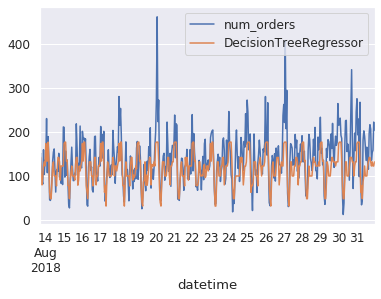

In [53]:
show_plot_compare_prediction_test(df.copy(), 'DecisionTreeRegressor',best_metrics_decision_tree_regressor)

Дерево решений хуже описывает пики и увеличение заказов в августе.

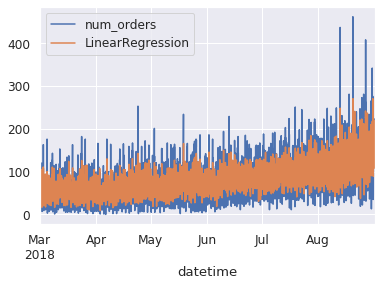

In [40]:
show_plot_compare_prediction(df.copy(), 'LinearRegression',best_metrics_linear_regression)

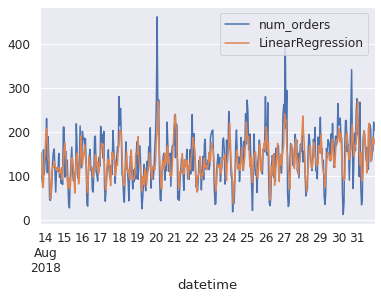

In [54]:
show_plot_compare_prediction_test(df.copy(), 'LinearRegression',best_metrics_linear_regression)

Линейная регрессия лучше дерева решений попадает в августовские пики визуально, и немного их повторяет. И её прогнозы более оптимистичны, так как ниже её нижней кромки реальные значения меньше, чем она предсказывает.

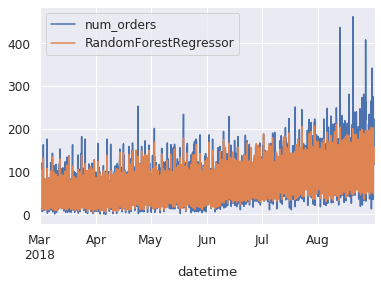

In [41]:
show_plot_compare_prediction(df.copy(), 'RandomForestRegressor',best_metrics_random_forest_regressor)

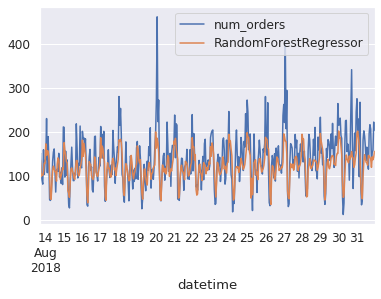

In [55]:
show_plot_compare_prediction_test(df.copy(), 'RandomForestRegressor',best_metrics_random_forest_regressor)


В целом случайный лес хорошо предсказывает общий тренд и покрывает пики, кроме августовских.